<a href="https://colab.research.google.com/github/FernandoRizo/BioKnee/blob/main/U_Net_BioKnee_Algoritmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentación automatica con U-Net**

In [4]:
!pip install pynrrd

Montar el drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Librerías y preprocesamiento

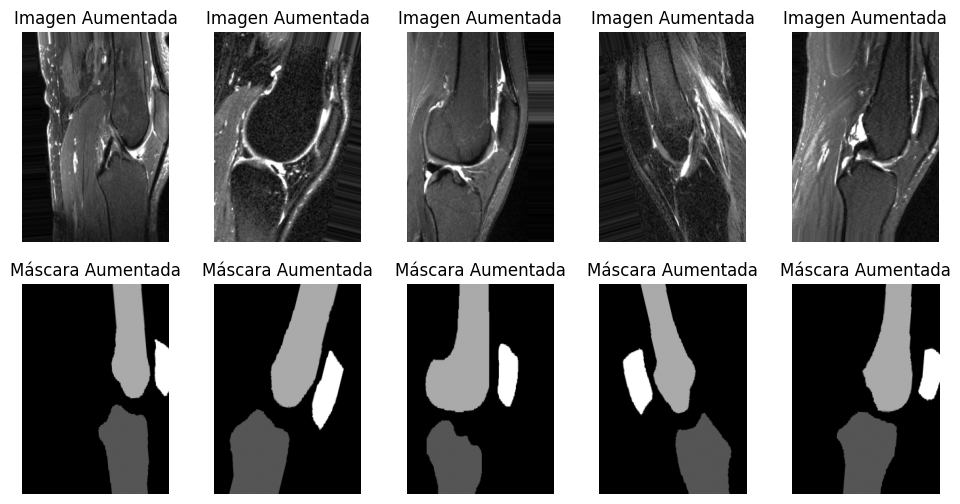

In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from google.colab import drive
import cv2  # Para redimensionar imágenes .nrrd
import nrrd  # Para cargar archivos .nrrd

# ================================
# Parámetros y directorios para rótula
# ================================
# Directorios de imágenes y máscaras
image_dir = '/content/drive/MyDrive/Equipo Trifuerza/Datos/Data set grises/Dataset mezclado 2D'
mask_dir  = '/content/drive/MyDrive/Equipo Trifuerza/Datos/Data set grises/Mascaras mezcladas'

# Parámetros de la imagen y segmentación
IMG_HEIGHT = 320
IMG_WIDTH = 224
IMG_CHANNELS = 1      # Imágenes en escala de grises
NUM_CLASSES = 4       # Ejemplo: Rótula, tibia, fémur, fondo
batch_size = 8

# Filtrar archivos válidos (.nrrd y .bmp)
valid_extensions = ('.nrrd', '.bmp')
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)])
mask_files  = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(valid_extensions)])
assert len(image_files) == len(mask_files), "La cantidad de imágenes y máscaras debe ser la misma"

# ================================
# Función personalizada para cargar imágenes
# ================================
def load_image_custom(filepath, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale'):
    ext = os.path.splitext(filepath)[1].lower()
    if ext == '.nrrd':
        # Cargar usando la librería nrrd
        img_data, header = nrrd.read(filepath)
        # Dependiendo del color_mode, procesamos la imagen:
        if color_mode == 'grayscale':
            # Si la imagen es a color, convertirla a escala de grises (promediando canales)
            if img_data.ndim == 3 and img_data.shape[-1] > 1:
                img_data = np.mean(img_data, axis=-1)
            # Asegurarse de que la imagen sea 2D antes de redimensionar
            # Redimensionar usando cv2 (cv2.resize requiere (ancho, alto))
            img_resized = cv2.resize(img_data, (target_size[1], target_size[0]))
            # Agregar la dimensión del canal
            img_resized = np.expand_dims(img_resized, axis=-1)
            return img_resized
        elif color_mode == 'rgb':
            # Si es color, se espera que la imagen tenga 3 canales
            # En caso de tener una sola banda, se replicará
            if img_data.ndim == 2:
                img_data = np.stack((img_data,)*3, axis=-1)
            img_resized = cv2.resize(img_data, (target_size[1], target_size[0]))
            return img_resized
        else:
            raise ValueError("Modo de color no soportado: " + color_mode)
    else:
        # Para otros formatos (.bmp), usamos load_img de Keras
        return img_to_array(load_img(filepath, target_size=target_size, color_mode=color_mode))

# ================================
# Cargar y preprocesar imágenes y máscaras
# ================================
images = []
masks = []

for img_file, msk_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, img_file)
    mask_path  = os.path.join(mask_dir, msk_file)

    # Cargar la imagen y normalizar (valores entre 0 y 1)
    img = load_image_custom(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    img = img.astype('float32') / 255.0

    # Cargar la máscara (se espera que contenga índices de clase)
    mask = load_image_custom(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    mask = mask.astype(np.int64)
    #Rotar la máscara 90 grados a la izquierda
    mask = np.rot90(mask, k=3, axes=(0, 1))  # 90° horario
    # Redimensiona la máscara para que tenga nuevamente el tamaño
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST) # → (H, W, 1)
    # VOLTEO HORIZONTAL para corregir el “espejo”
    mask = np.fliplr(mask)
    # Aseguramos (H, W, 1)
    # mask = np.expand_dims(mask, axis=-1) comentada por problema de dimensiones
    # Agragar la dimensión del canal para que la máscara tenga forma(alto,ancho,1)
    mask = np.expand_dims(mask, axis=-1)
    images.append(img)
    masks.append(mask)

# Convertir listas a arrays de NumPy
images = np.array(images)
masks  = np.array(masks)      # → (N, 320,224,1,1)

# Dividir en conjuntos de entrenamiento y validación (por ejemplo, 90% train, 10% val)
images_train, images_val, masks_train, masks_val = train_test_split(
    images, masks, test_size=0.1, random_state=42
)


# ================================
# Crear generadores de datos con aumento (augmentation)
# ================================
data_gen_args = dict(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2) Generadores
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**data_gen_args)

seed = 42
# — Ajuste no estrictamente necesario, pero útil si algún escalador lo requiere
image_datagen.fit(images_train, augment=True, seed=seed)
mask_datagen.fit(masks_train,  augment=True, seed=seed)

train_img_gen = image_datagen.flow(images_train,
                                   batch_size=batch_size,
                                   seed=seed)
train_mask_gen = mask_datagen.flow(masks_train,
                                   batch_size=batch_size,
                                   seed=seed)

def train_generator():
    while True:
        imgs = next(train_img_gen)
        msks = next(train_mask_gen)
        yield imgs, msks


# (Opcional) Visualizar algunas imágenes y máscaras aumentadas
batch = next(train_generator())
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(batch[0][i].squeeze(), cmap='gray')
    plt.title("Imagen Aumentada")
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(batch[1][i].squeeze(), cmap='gray')
    plt.title("Máscara Aumentada")
    plt.axis('off')
plt.show()

Definición U-Net multiclase y entrenamiento

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.5823 - loss: 1.4227 - val_accuracy: 0.6979 - val_loss: 0.9072
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.6915 - loss: 0.8809 - val_accuracy: 0.6979 - val_loss: 0.8763
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.7018 - loss: 0.8306 - val_accuracy: 0.6979 - val_loss: 0.8481
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 405ms/step - accuracy: 0.6882 - loss: 0.8425 - val_accuracy: 0.6979 - val_loss: 0.8376
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - accuracy: 0.6990 - loss: 0.8177 - val_accuracy: 0.6979 - val_loss: 0.8307
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 422ms/step - accuracy: 0.6910 - loss: 0.8195 - val_accuracy: 0.6979 - val_loss: 0.7944
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - accuracy: 0.6989 - loss: 0.7957 - val_accuracy: 0.6979 - val_loss: 0.7213
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step - accuracy: 0.7029 - loss: 0.7432 - val_accuracy: 0.6

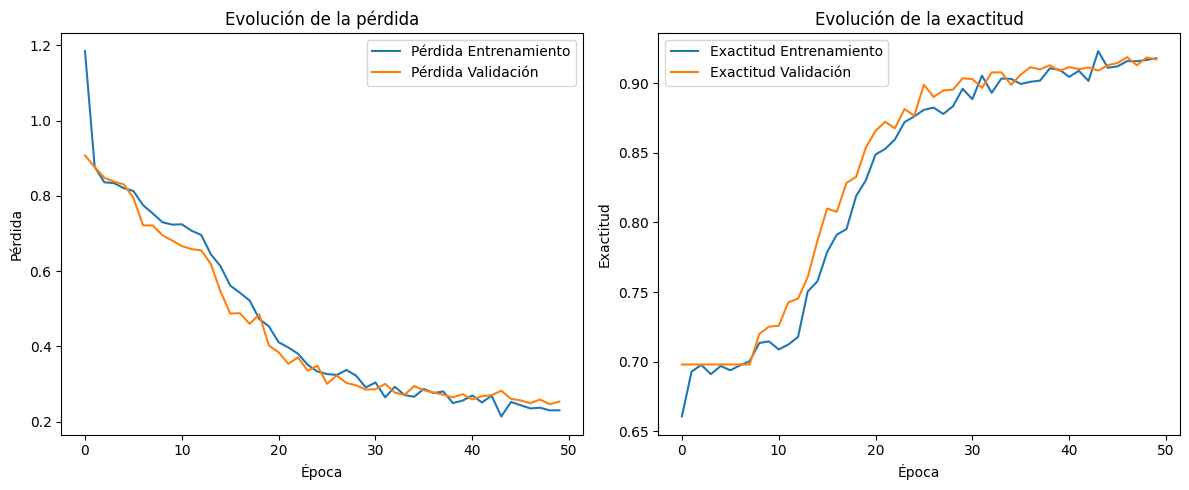

In [10]:
# Definir la U-Net para segmentación multi‑clase
# ================================
from tensorflow.keras import layers, models, optimizers

def U_net(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=NUM_CLASSES):
    inputs = tf.keras.Input(shape=input_shape)

    # Bloque Down 1
    conv1 = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    conv1 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv1)
    #conv1 = layers.Dropout(0.3)(conv1)            # 30% de neuronas apaga
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Bloque Down 2
    conv2 = layers.Conv2D(128, 3, padding='same', activation='relu')(pool1)
    conv2 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv2)
    #conv2 = layers.Dropout(0.3)(conv2)            # 30% de neuronas apaga
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bloque Down 3
    conv3 = layers.Conv2D(256, 3, padding='same', activation='relu')(pool2)
    conv3 = layers.Conv2D(256, 3, padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bloque intermedio
    conv4 = layers.Conv2D(512, 3, padding='same', activation='relu')(pool3)
    conv4 = layers.Conv2D(512, 3, padding='same', activation='relu')(conv4)

    # Up 1
    up1 = layers.UpSampling2D((2, 2))(conv4)
    concat1 = layers.concatenate([up1, conv3])
    conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(concat1)
    conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(conv5)

    # Up 2
    up2 = layers.UpSampling2D((2, 2))(conv5)
    concat2 = layers.concatenate([up2, conv2])
    conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(concat2)
    conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv6)

    # Up 3
    up3 = layers.UpSampling2D((2, 2))(conv6)
    concat3 = layers.concatenate([up3, conv1])
    conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(concat3)
    conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv7)

    # Capa de salida: NUM_CLASSES canales con activación softmax
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = models.Model(inputs, outputs)
    return model

model = U_net()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

steps_per_epoch = len(images_train) // batch_size
validation_steps = len(images_val) // batch_size

# ================================
# Entrenamiento
# ================================

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

"""checkpoint_path = '/content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5'
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',        # métrica a monitorear
    save_best_only=True,       # guarda sólo cuando mejora
    save_weights_only=False,   # guarda todo el modelo (arquitectura + pesos)
    mode='auto',               # 'min' para pérdidas, 'max' para métricas como accuracy
    verbose=1                  # imprime mensaje cuando guarda
)"""

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitorea la pérdida en validación
    patience=8,                 # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True   # Restaura los mejores pesos obtenidos durante el entrenamiento
)

# 3) Opcional: validación SIN augmentación
#    simplemente pasamos los arrays puros
val_data = (images_val, masks_val)
# Entrenamiento del modelo con EarlyStopping

history = model.fit(
    train_generator(),
    steps_per_epoch = len(images_train) // batch_size,
    epochs           = 50,
    validation_data  = val_data,
    validation_steps = None,          # al usar tuplas, no es necesario
    callbacks        = [early_stop] #checkpoint_cb
)

"""history = model.fit(
    images_train,
    masks_train,
    train_generator(),
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_data=(images_val, masks_val),
    validation_data=val_generator(),
    validation_steps=validation_steps,
    epochs=45,                 # Número máximo de épocas
    #callbacks=[early_stop]     # Añadido el callback aquí
)"""

# Guardar el modelo entrenado
# Ruta personalizada en Drive
model_path = '/content/drive/MyDrive/Equipo Trifuerza/Códigos fuentes/Modelos entrenados/U-Net_entrenada_DA_50e_GPU.h5'
model.save(model_path)

# ================================
# Graficar curvas de entrenamiento
# ================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Exactitud Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Exactitud Validación')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.title('Evolución de la exactitud')
plt.legend()
plt.tight_layout()
plt.show()



### Visualización mascaras automáticas

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Shapes → preds_classes: (4, 320, 224)  true_classes: (4, 320, 224)


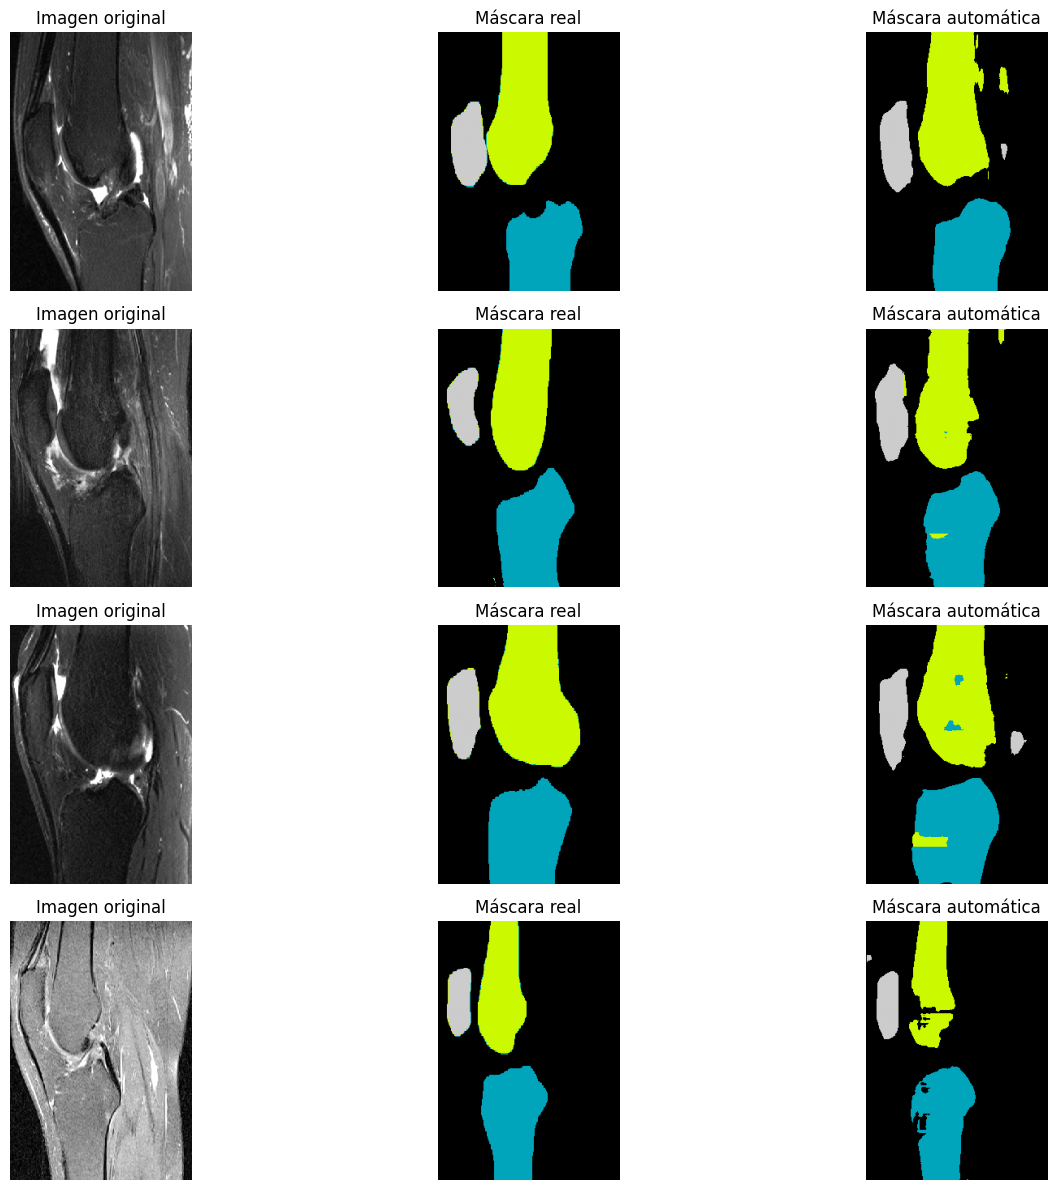

In [11]:
# Elegir muestras
num_samples   = 4
sample_images = images_val[:num_samples]
sample_masks  = masks_val[:num_samples]

# Predicciones
preds = model.predict(sample_images)
preds_classes = np.argmax(preds, axis=-1)

# Quitar cualquier dimensión extra
true_classes = np.squeeze(sample_masks)

print("Shapes → preds_classes:", preds_classes.shape,
      " true_classes:", true_classes.shape)
#   Deben coincidir en (5, 320, 224)

# Visualización
plt.figure(figsize=(15, num_samples * 3))
for i in range(num_samples):
    # Original
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title('Imagen original'); plt.axis('off')
    # Máscara real
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(true_classes[i], cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.title('Máscara real'); plt.axis('off')
    # Máscara predicha
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(preds_classes[i], cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.title('Máscara automática'); plt.axis('off')

plt.tight_layout()
plt.show()


##Suavizar contorno de la mascara


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


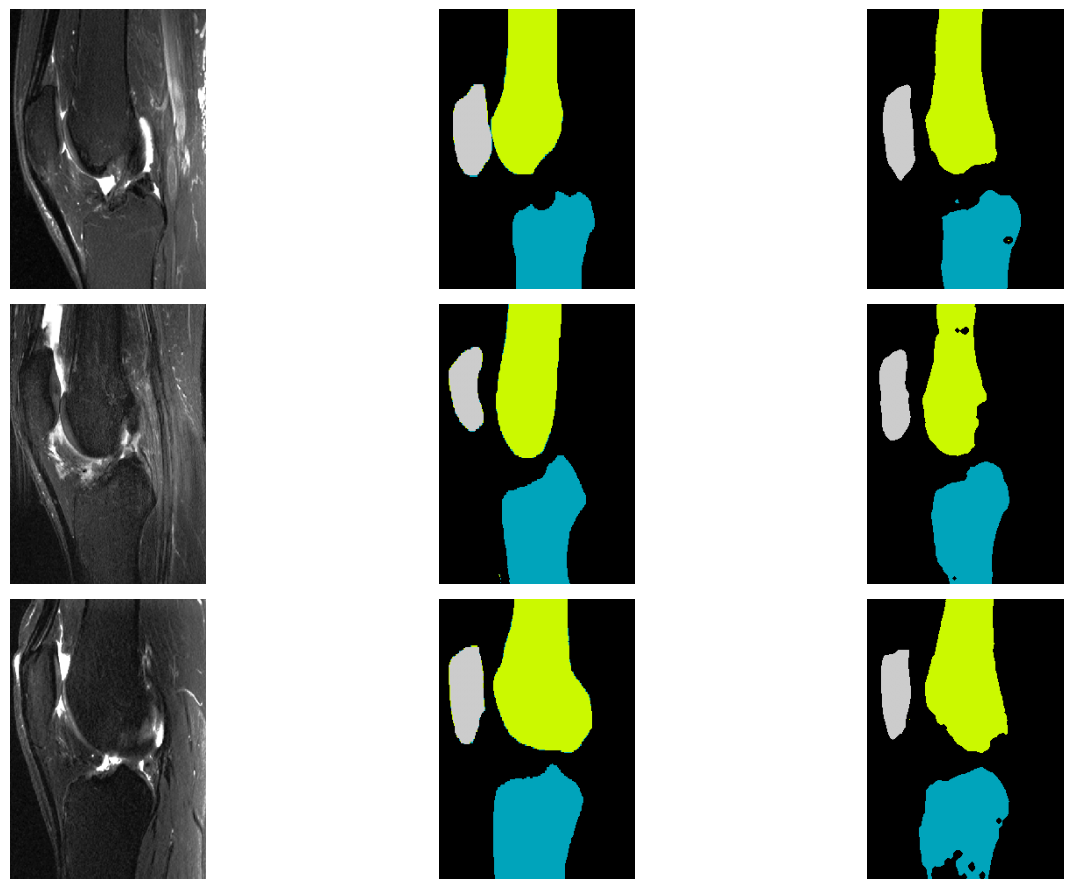

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 1. Cargar el modelo
model_path = '/content/drive/MyDrive/Equipo Trifuerza/Códigos fuentes/Modelos entrenados/U-Net_entrenada_DA_45e_GPU.h5'
model = load_model(model_path)

# 2. Preparar muestras
num_samples   = 3
sample_images = images_val[:num_samples]            # ya normalizadas
sample_masks  = masks_val[:num_samples]
true_classes  = np.squeeze(sample_masks)            # (5, H, W)

# 3. Inferencia
preds = model.predict(sample_images)
preds_classes = np.argmax(preds, axis=-1)           # (5, H, W)

# 4. Post-procesado morfológico
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
preds_eroded = []
for pc in preds_classes:
    eroded_label = np.zeros_like(pc, dtype=np.uint8)
    for lbl in [1, 2, 3]:
        bin_mask = (pc == lbl).astype(np.uint8) * 255
        eroded = cv2.erode(bin_mask, kernel, iterations=2)
        eroded_label[eroded > 0] = lbl
    preds_eroded.append(eroded_label)
preds_eroded = np.stack(preds_eroded, axis=0)

# 5. Visualización
plt.figure(figsize=(15, num_samples * 3))
for i in range(num_samples):
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(true_classes[i], cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off')
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(preds_eroded[i], cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off')
plt.tight_layout()
plt.show()


Visualización


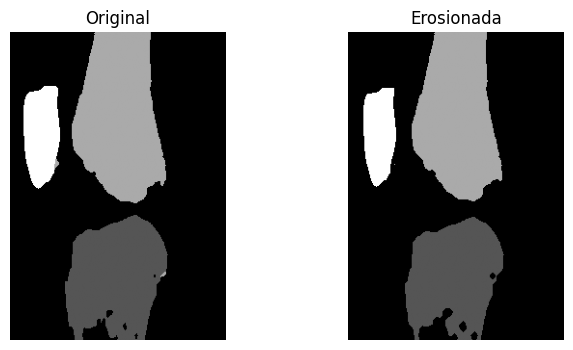

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(pc, cmap='gray');        axs[0].set_title('Original');  axs[0].axis('off')
axs[1].imshow(eroded_label, cmap='gray'); axs[1].set_title('Erosionada'); axs[1].axis('off')
plt.show()

##Obtención de centroides

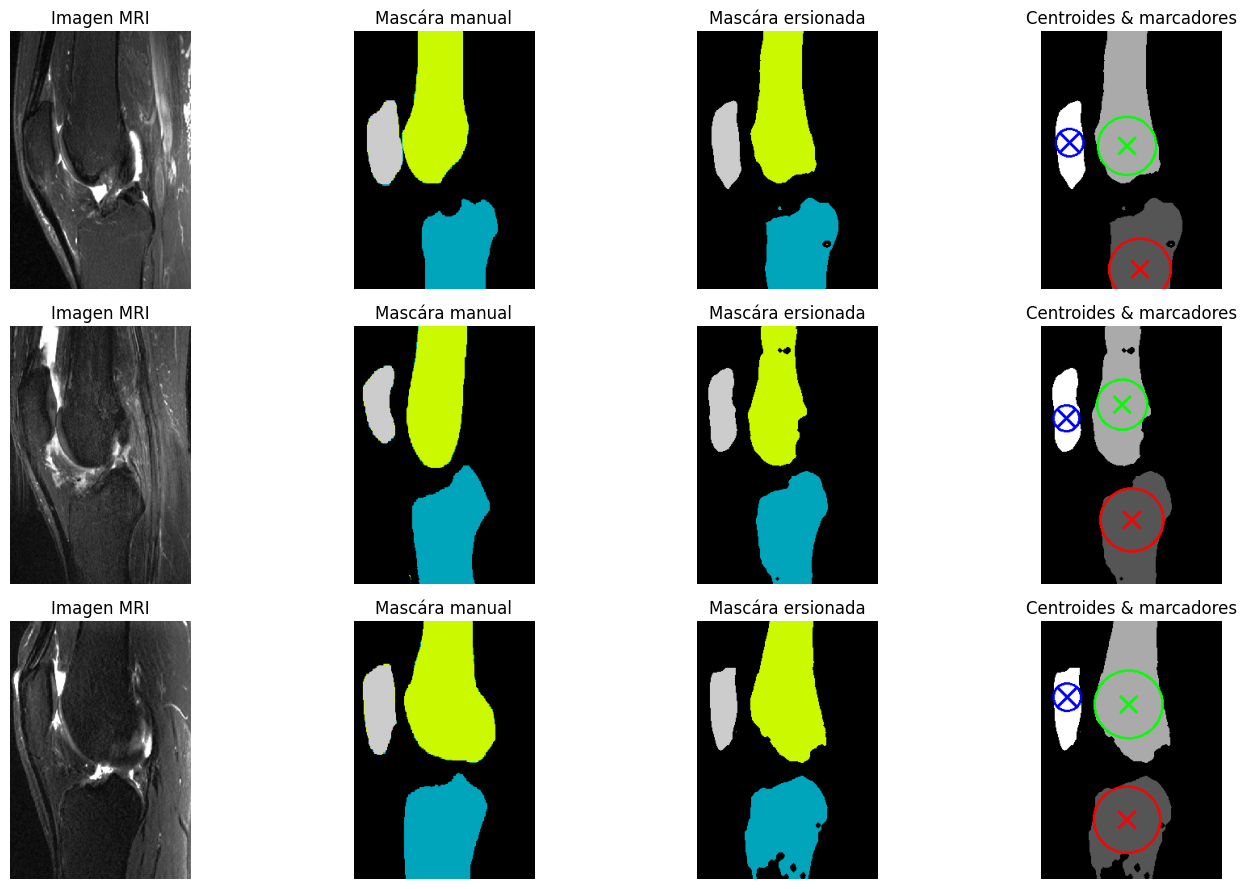

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

num_samples = preds_eroded.shape[0]

# Colores BGR para cada hueso
label_colors = {
    1: (0,   0, 255),   # fémur → rojo
    2: (0, 255,   0),   # tibia → verde
    3: (255, 0,   0),   # rótula → azul
}

plt.figure(figsize=(15, num_samples * 3))

for i in range(num_samples):
    img     = sample_images[i].squeeze()   # escala de grises
    true_m  = true_classes[i]
    er_mask = preds_eroded[i]              # (H, W) con etiquetas 0–3

    # — Subplot 1: input
    plt.subplot(num_samples, 4, i*4 + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off'); plt.title('Imagen MRI')

    # — Subplot 2: ground-truth
    plt.subplot(num_samples, 4, i*4 + 2)
    plt.imshow(true_m, cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off'); plt.title('Mascára manual')

    # Preparamos la imagen BGR para dibujar círculos y cruces
    vis = cv2.cvtColor(
        (er_mask * (255/(NUM_CLASSES-1))).astype(np.uint8),
        cv2.COLOR_GRAY2BGR
    )

    # Para cada etiqueta calculamos núcleo y centroides
    for lbl, color in label_colors.items():
        bin_mask = (er_mask == lbl).astype(np.uint8)
        if bin_mask.sum() == 0:
            continue

        # Distance transform para hallar el punto más interior
        dt = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 5)
        _, maxVal, _, maxLoc = cv2.minMaxLoc(dt)
        cx, cy  = maxLoc
        radius  = int(maxVal)

        # Dibujar círculo
        cv2.circle(vis, (cx, cy), radius,
                   color=color, thickness=2)

        # Dibujar la “X” en el centro
        cv2.drawMarker(vis, (cx, cy),
                       color=color,
                       markerType=cv2.MARKER_TILTED_CROSS,
                       markerSize=20,
                       thickness=2)

    # — Subplot 3: máscara erosionada
    plt.subplot(num_samples, 4, i*4 + 3)
    plt.imshow(er_mask, cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off'); plt.title('Mascára ersionada')

    # — Subplot 4: visualización final con círculos y cruces
    plt.subplot(num_samples, 4, i*4 + 4)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.title('Centroides & marcadores')

plt.tight_layout()
plt.show()


##Calculo del angulo Q

Sample 0: ángulo Q = 57.78°
Sample 1: ángulo Q = 71.11°
Sample 2: ángulo Q = 57.29°


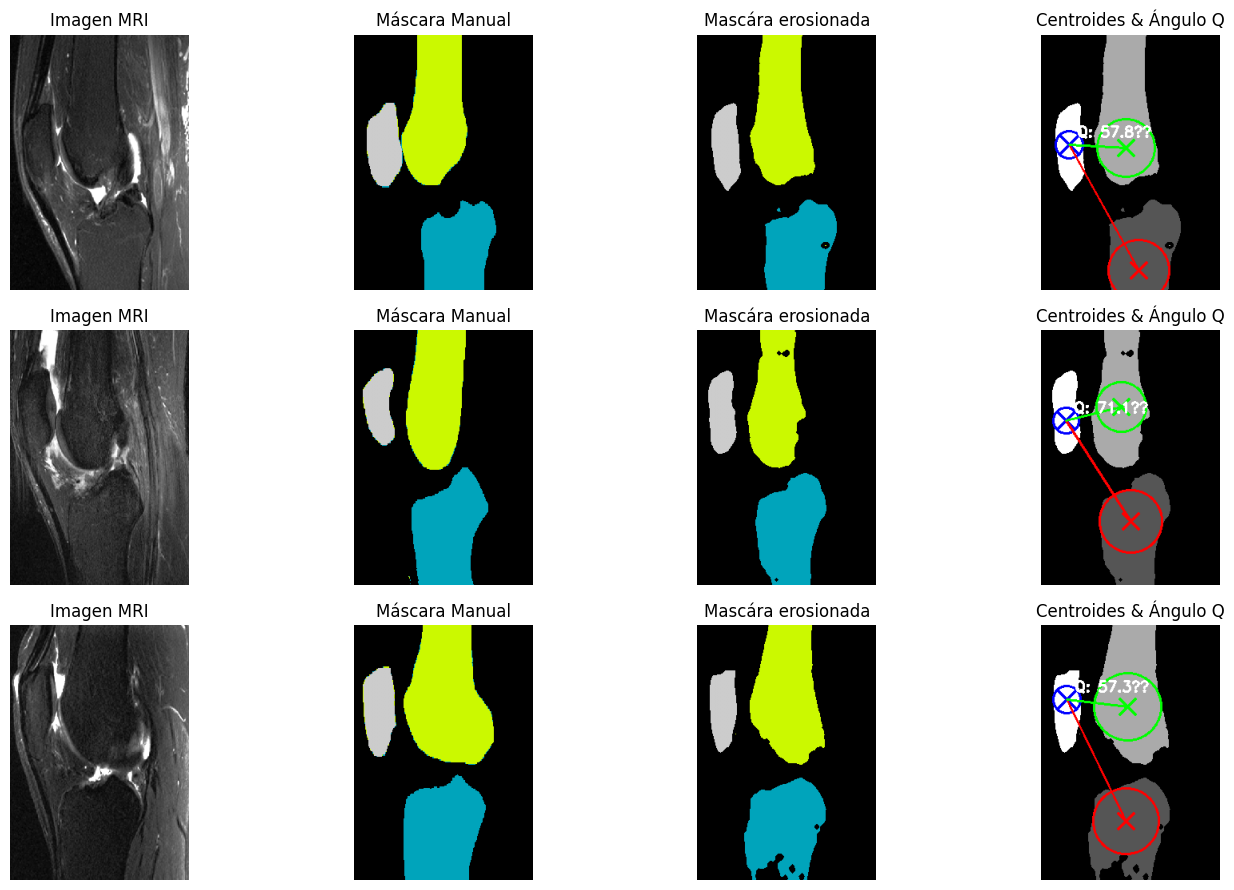

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Función para calcular ángulo entre dos vectores
# -------------------------------------------------------------------
def calcular_angulo(v1, v2):
    dot   = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    angle_rad = np.arccos(dot / (norm1 * norm2))
    return np.degrees(angle_rad)

# -------------------------------------------------------------------
# Parámetros e inicialización de la figura
# -------------------------------------------------------------------
num_samples = preds_eroded.shape[0]
label_colors = {
    1: (0,   0, 255),   # fémur → rojo
    2: (0, 255,   0),   # tibia → verde
    3: (255, 0,   0),   # rótula → azul
}

plt.figure(figsize=(15, num_samples * 3))

for i in range(num_samples):
    # — Datos de entrada y máscaras
    img     = sample_images[i].squeeze()
    true_m  = true_classes[i]
    er_mask = preds_eroded[i]

    # — Subplot 1: input
    plt.subplot(num_samples, 4, i*4 + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off'); plt.title('Imagen MRI')

    # — Subplot 2: ground-truth
    plt.subplot(num_samples, 4, i*4 + 2)
    plt.imshow(true_m, cmap='nipy_spectral', vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off'); plt.title('Máscara Manual')

    # — Preparamos BGR para dibujar
    vis = cv2.cvtColor(
        (er_mask * (255/(NUM_CLASSES-1))).astype(np.uint8),
        cv2.COLOR_GRAY2BGR
    )

    # — Detectamos centroides con distanceTransform
    centroids = {}
    for lbl, color in label_colors.items():
        bin_mask = (er_mask == lbl).astype(np.uint8)
        if bin_mask.sum() == 0:
            continue

        dt = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 5)
        _, maxVal, _, maxLoc = cv2.minMaxLoc(dt)
        cx, cy = maxLoc
        centroids[lbl] = (cx, cy)

        # Dibujar círculo y “X”
        radius = int(maxVal)
        cv2.circle(vis, (cx, cy), radius, color=color, thickness=2)
        cv2.drawMarker(vis, (cx, cy), color=color,
                       markerType=cv2.MARKER_TILTED_CROSS,
                       markerSize=20, thickness=2)

    # — Cálculo del ángulo Q si están los tres centroides
    if all(k in centroids for k in (1, 2, 3)):
        p_femur  = np.array(centroids[1])
        p_tibia  = np.array(centroids[2])
        p_patela = np.array(centroids[3])

        # Vector desde rótula a fémur y desde rótula a tibia
        v1 = p_femur  - p_patela
        v2 = p_tibia  - p_patela
        ang_Q = calcular_angulo(v1, v2)

        # — Dibujo de las líneas que forman el ángulo Q
        cv2.line(vis,
                 tuple(p_patela),
                 tuple(p_femur),
                 label_colors[1],
                 thickness=2)
        cv2.line(vis,
                 tuple(p_patela),
                 tuple(p_tibia),
                 label_colors[2],
                 thickness=2)

        # Anotar en la imagen el valor de Q
        cv2.putText(vis,
                    f"Q: {ang_Q:.1f}°",
                    (int(p_patela[0]+10), int(p_patela[1]-10)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (255,255,255), 2)

        print(f"Sample {i}: ángulo Q = {ang_Q:.2f}°")
    else:
        print(f"Sample {i}: faltan centroides para calcular Q.")

    # — Subplot 3: máscara erosionada
    plt.subplot(num_samples, 4, i*4 + 3)
    plt.imshow(er_mask, cmap='nipy_spectral', vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off'); plt.title('Mascára erosionada')

    # — Subplot 4: visualización final
    plt.subplot(num_samples, 4, i*4 + 4)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.title('Centroides & Ángulo Q')

plt.tight_layout()
plt.show()
